# Create HuggingFace Dataset from Element Highlights

This notebook processes element-highlights snapshots into a HuggingFace dataset with image-caption pairs.

## 1. Install Libraries and Import Dependencies

In [1]:
# Install required packages
!pip install pandas numpy matplotlib tqdm datasets huggingface_hub pillow

import os
import glob
import json
import shutil
import hashlib
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import Dataset, Image as DSImage, DatasetDict, Features, Value
from huggingface_hub import login, HfApi, create_repo

## 2. Configuration

In [2]:
# Configuration
HF_USERNAME = "Slyracoon23"  # Your HuggingFace username
DATASET_NAME = "rrvideo-element-highlights"  # Name for your dataset
ELEMENT_HIGHLIGHTS_DIR = "../element-highlights"  # Path to element-highlights directory
PROCESSED_DATA_DIR = "processed_data"  # Directory to store processed data

# Create directories
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DATA_DIR, "images"), exist_ok=True)

## 3. Login to HuggingFace

In [3]:
# ... existing code ...
from huggingface_hub import login, whoami
try:

    # Try to get user info to check if already logged in
    user_info = whoami()
    print(f"Already logged in as: {user_info['name']}")
except Exception:
    print("Not logged in. Please login...")
    # Use the simpler login() function
    try:
        login()
        print("Login successful!")
    except Exception as e:
        print(f"Error during login: {e}")
        print("Please make sure you're logged in before proceeding.")

# Create repository if it doesn't exist
try:
    create_repo(
        repo_id=f"{HF_USERNAME}/{DATASET_NAME}",
        repo_type="dataset",
        exist_ok=True,
        private=False
    )
    print(f"Repository {HF_USERNAME}/{DATASET_NAME} is ready")
except Exception as e:
    print(f"Error creating repository: {e}")
# ... existing code ...


Already logged in as: Slyracoon23
Repository Slyracoon23/rrvideo-element-highlights is ready


## 4. Helper Functions

In [4]:
def parse_snapshot_name(snapshot_dir):
    """Extract snapshot ID and timestamp from directory name"""
    base_name = os.path.basename(snapshot_dir)
    parts = base_name.split('_')
    if len(parts) >= 3:
        try:
            snapshot_id = int(parts[1])
            timestamp = int(parts[2])
            return {
                "snapshot_id": snapshot_id,
                "timestamp": timestamp,
                "snapshot_name": base_name
            }
        except ValueError:
            print(f"Could not parse snapshot name: {base_name}")
    return None

def generate_image_hash(img_path):
    """Generate a hash for the image to prevent duplicates"""
    try:
        with open(img_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except Exception as e:
        print(f"Error generating hash for {img_path}: {e}")
        return None

def extract_element_metadata(img_path):
    """Extract basic metadata from the image"""
    try:
        img = Image.open(img_path)
        width, height = img.size
        return {
            "width": width,
            "height": height,
            "aspect_ratio": width / height if height > 0 else 0
        }
    except Exception as e:
        print(f"Error extracting metadata from {img_path}: {e}")
        return {}

def generate_caption(element_data):
    """Generate a caption for the element"""
    element_id = element_data.get("element_id", "unknown")
    snapshot_id = element_data.get("snapshot_id", "unknown")
    metadata = element_data.get("metadata", {})
    
    # Basic caption
    caption = f"UI element {element_id} from snapshot {snapshot_id}"
    
    # Add dimensions if available
    if "width" in metadata and "height" in metadata:
        caption += f", dimensions {metadata['width']}x{metadata['height']} pixels"
    
    return caption

## 5. Process Snapshots

In [5]:
def process_snapshot(snapshot_dir):
    """Process a single snapshot directory and return image-caption pairs"""
    snapshot_info = parse_snapshot_name(snapshot_dir)
    if not snapshot_info:
        return []
    
    # Get all element images in the directory
    element_images = [f for f in glob.glob(os.path.join(snapshot_dir, "element_*.png"))]
    
    data = []
    
    for img_path in element_images:
        # Get element ID from filename
        element_id = os.path.basename(img_path).replace("element_", "").replace(".png", "")
        
        # Generate a hash for the image
        img_hash = generate_image_hash(img_path)
        if not img_hash:
            continue
        
        # Copy image to processed directory with hash name
        new_img_path = os.path.join(PROCESSED_DATA_DIR, "images", f"{img_hash}.png")
        shutil.copy(img_path, new_img_path)
        
        # Extract metadata
        metadata = extract_element_metadata(img_path)
        
        # Prepare data entry
        element_data = {
            "image_path": new_img_path,
            "original_path": img_path,
            "image_hash": img_hash,
            "snapshot_id": snapshot_info["snapshot_id"],
            "timestamp": snapshot_info["timestamp"],
            "element_id": element_id,
            "snapshot_name": snapshot_info["snapshot_name"],
            "metadata": metadata
        }
        
        # Generate caption
        element_data["caption"] = generate_caption(element_data)
        
        data.append(element_data)
    
    return data

def process_all_snapshots():
    """Process all snapshot directories and compile dataset"""
    # Get all snapshot directories
    snapshot_dirs = glob.glob(os.path.join(ELEMENT_HIGHLIGHTS_DIR, "snapshot_*"))
    print(f"Found {len(snapshot_dirs)} snapshot directories")
    
    all_data = []
    
    for snapshot_dir in tqdm(snapshot_dirs, desc="Processing snapshots"):
        snapshot_data = process_snapshot(snapshot_dir)
        all_data.extend(snapshot_data)
    
    print(f"Processed {len(all_data)} elements across {len(snapshot_dirs)} snapshots")
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(all_data)
    
    # Save intermediate CSV for inspection
    df.to_csv(os.path.join(PROCESSED_DATA_DIR, "element_data.csv"), index=False)
    
    return df

# Process all snapshots
df = process_all_snapshots()

Found 516 snapshot directories


Processing snapshots:   0%|          | 0/516 [00:00<?, ?it/s]

Processed 38569 elements across 516 snapshots


## 6. Analyze and Clean Data

In [10]:
# Display basic statistics
print("Dataset Statistics:")
print(f"Total number of elements: {len(df)}")
print(f"Number of unique snapshots: {df['snapshot_id'].nunique()}")
print(f"Number of unique image hashes: {df['image_hash'].nunique()}")

# Extract width and height from metadata for easier access
df['width'] = df['metadata'].apply(lambda x: x.get('width', 0))
df['height'] = df['metadata'].apply(lambda x: x.get('height', 0))
df['aspect_ratio'] = df['metadata'].apply(lambda x: x.get('aspect_ratio', 0))

# Check for duplicate images
duplicates = df[df.duplicated(subset=['image_hash'], keep='first')]
print(f"Found {len(duplicates)} duplicate images (based on hash)")

# Remove duplicates if any
if len(duplicates) > 0:
    df = df.drop_duplicates(subset=['image_hash'], keep='first')
    print(f"After removing duplicates: {len(df)} elements")

# Display the first row of the DataFrame to understand its structure
print("\nFirst row of the DataFrame:")
print(df.iloc[0].to_dict())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Check for invalid dimensions (zero or negative width/height)
invalid_dimensions = df[(df['width'] <= 0) | (df['height'] <= 0)]
print(f"\nFound {len(invalid_dimensions)} elements with invalid dimensions")

# Remove elements with invalid dimensions if any
if len(invalid_dimensions) > 0:
    df = df[(df['width'] > 0) & (df['height'] > 0)]
    print(f"After removing invalid dimensions: {len(df)} elements")

# Display summary statistics for numerical columns
print("\nSummary statistics for dimensions:")
print(df[['width', 'height', 'aspect_ratio']].describe())
df

Dataset Statistics:
Total number of elements: 118
Number of unique snapshots: 3
Number of unique image hashes: 118
Found 0 duplicate images (based on hash)

First row of the DataFrame:
{'image_path': 'processed_data/images/779afeeba597c8022f789b268e93f8d9.png', 'original_path': '../element-highlights/snapshot_395_1739845543701/element_64.png', 'image_hash': '779afeeba597c8022f789b268e93f8d9', 'snapshot_id': 395, 'timestamp': 1739845543701, 'element_id': '64', 'snapshot_name': 'snapshot_395_1739845543701', 'metadata': {'width': 1280, 'height': 720, 'aspect_ratio': 1.7777777777777777}, 'caption': 'UI element 64 from snapshot 395, dimensions 1280x720 pixels', 'width': 1280, 'height': 720, 'aspect_ratio': 1.7777777777777777}

Missing values in each column:
image_path       0
original_path    0
image_hash       0
snapshot_id      0
timestamp        0
element_id       0
snapshot_name    0
metadata         0
caption          0
width            0
height           0
aspect_ratio     0
dtype: in

,image_path,original_path,image_hash,snapshot_id,timestamp,element_id,snapshot_name,metadata,caption,width,height,aspect_ratio
0,processed_data/images/779afeeba597c8022f789b26...,../element-highlights/snapshot_395_17398455437...,779afeeba597c8022f789b268e93f8d9,395,1739845543701,64,snapshot_395_1739845543701,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 64 from snapshot 395, dimensions 12...",1280,720,1.777778
2,processed_data/images/e2cf657b476c409f7cb34cff...,../element-highlights/snapshot_395_17398455437...,e2cf657b476c409f7cb34cff44650c78,395,1739845543701,58,snapshot_395_1739845543701,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 58 from snapshot 395, dimensions 12...",1280,720,1.777778
3,processed_data/images/f2ee0b413e2da0d528c2cb6f...,../element-highlights/snapshot_395_17398455437...,f2ee0b413e2da0d528c2cb6f7ca93c32,395,1739845543701,59,snapshot_395_1739845543701,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 59 from snapshot 395, dimensions 12...",1280,720,1.777778
4,processed_data/images/169692b03151735d447d70da...,../element-highlights/snapshot_395_17398455437...,169692b03151735d447d70da169e268a,395,1739845543701,71,snapshot_395_1739845543701,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 71 from snapshot 395, dimensions 12...",1280,720,1.777778
6,processed_data/images/b4046cd6ad7f075409151bb1...,../element-highlights/snapshot_395_17398455437...,b4046cd6ad7f075409151bb101904b21,395,1739845543701,73,snapshot_395_1739845543701,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 73 from snapshot 395, dimensions 12...",1280,720,1.777778
...,...,...,...,...,...,...,...,...,...,...,...,...
29095,processed_data/images/f731cbf483da9919c86b8e41...,../element-highlights/snapshot_515_17398455577...,f731cbf483da9919c86b8e41e9f69538,515,1739845557705,68,snapshot_515_1739845557705,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 68 from snapshot 515, dimensions 12...",1280,720,1.777778
29096,processed_data/images/bcd79f819924b1c8616380bf...,../element-highlights/snapshot_515_17398455577...,bcd79f819924b1c8616380bfea81aa66,515,1739845557705,40,snapshot_515_1739845557705,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 40 from snapshot 515, dimensions 12...",1280,720,1.777778
29097,processed_data/images/4b0254896d2a79d9ff628f19...,../element-highlights/snapshot_515_17398455577...,4b0254896d2a79d9ff628f19fbbc85ac,515,1739845557705,54,snapshot_515_1739845557705,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 54 from snapshot 515, dimensions 12...",1280,720,1.777778
29098,processed_data/images/bba5ce15d2004d65a04d289a...,../element-highlights/snapshot_515_17398455577...,bba5ce15d2004d65a04d289adb75743a,515,1739845557705,55,snapshot_515_1739845557705,"{'width': 1280, 'height': 720, 'aspect_ratio':...","UI element 55 from snapshot 515, dimensions 12...",1280,720,1.777778


## 7. Create and Upload HuggingFace Dataset

In [14]:
def create_and_upload_dataset(df):
    """Create HuggingFace dataset and upload to Hub"""
    # Convert metadata dict to string to avoid serialization issues
    df['metadata_str'] = df['metadata'].apply(json.dumps)
    
    # Convert to HuggingFace dataset - the index_col parameter is not supported
    # Reset the index to avoid including it in the dataset
    df_reset = df.reset_index(drop=True)
    dataset = Dataset.from_pandas(df_reset)
    
    # Define features
    features = Features({
        "image": DSImage(),
        "caption": Value("string"),
        "snapshot_id": Value("int64"),
        "timestamp": Value("int64"),
        "element_id": Value("string"),
        "image_hash": Value("string"),
        "snapshot_name": Value("string"),
        "metadata_str": Value("string"),
        "width": Value("int64"),
        "height": Value("int64"),
        "aspect_ratio": Value("float32")
    })
    
    # Convert image paths to actual images
    def process_example(example):
        image = Image.open(example["image_path"])
        return {
            "image": image,
            "caption": example["caption"],
            "snapshot_id": example["snapshot_id"],
            "timestamp": example["timestamp"],
            "element_id": example["element_id"],
            "image_hash": example["image_hash"],
            "snapshot_name": example["snapshot_name"],
            "metadata_str": example["metadata_str"],
            "width": example["width"],
            "height": example["height"],
            "aspect_ratio": example["aspect_ratio"]
        }
    
    # Apply the transformation
    dataset = dataset.map(
        process_example,
        remove_columns=["image_path", "original_path", "metadata"],
        features=features
    )
    
    # Split into train/validation/test sets (80/10/10 split)
    splits = dataset.train_test_split(test_size=0.2, seed=42)
    test_valid = splits["test"].train_test_split(test_size=0.5, seed=42)
    
    # Create DatasetDict
    dataset_dict = DatasetDict({
        "train": splits["train"],
        "validation": test_valid["train"],
        "test": test_valid["test"]
    })
    
    # Print split information
    print("Dataset splits:")
    for split, subset in dataset_dict.items():
        print(f"  {split}: {len(subset)} examples")
    
    # Push to hub
    dataset_dict.push_to_hub(
        f"{HF_USERNAME}/{DATASET_NAME}",
        private=False
    )
    
    print(f"Dataset uploaded to https://huggingface.co/datasets/{HF_USERNAME}/{DATASET_NAME}")
    return dataset_dict

# Create and upload dataset
print("Creating and uploading dataset...")
dataset_dict = create_and_upload_dataset(df)

Creating and uploading dataset...


Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Dataset splits:
  train: 94 examples
  validation: 12 examples
  test: 12 examples


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset uploaded to https://huggingface.co/datasets/Slyracoon23/rrvideo-element-highlights


## 8. Create Dataset Card

In [15]:
def create_dataset_card():
    """Create a dataset card with information about the dataset"""
    card = f"""
---
language:
- en
license: cc-by-4.0
task_categories:
- image-classification
- image-to-text
---

# Dataset Card for {DATASET_NAME}

## Dataset Description

This dataset contains UI element images extracted from web snapshots, along with captions describing each element.

### Dataset Summary

The dataset contains {len(df)} unique UI elements from {df['snapshot_id'].nunique()} different snapshots. Each element is associated with a caption describing its basic properties.

### Dataset Statistics

- Total elements: {len(df)}
- Unique snapshots: {df['snapshot_id'].nunique()}
- Average element width: {df['width'].mean():.2f} pixels
- Average element height: {df['height'].mean():.2f} pixels
- Average aspect ratio: {df['aspect_ratio'].mean():.2f}

## Dataset Structure

### Data Fields

- **image**: The UI element image
- **caption**: A description of the element
- **snapshot_id**: The snapshot identifier
- **timestamp**: When the snapshot was taken
- **element_id**: Identifier for the specific element
- **width**: The width of the element in pixels
- **height**: The height of the element in pixels
- **aspect_ratio**: The aspect ratio of the element

### Data Splits

- Train: {len(dataset_dict['train'])} examples (80%)
- Validation: {len(dataset_dict['validation'])} examples (10%)
- Test: {len(dataset_dict['test'])} examples (10%)
"""
    
    # Write dataset card to file
    readme_path = os.path.join(PROCESSED_DATA_DIR, "README.md")
    with open(readme_path, "w") as f:
        f.write(card)
    
    # Upload to HuggingFace Hub
    api = HfApi()
    api.upload_file(
        path_or_fileobj=readme_path,
        path_in_repo="README.md",
        repo_id=f"{HF_USERNAME}/{DATASET_NAME}",
        repo_type="dataset"
    )
    
    print(f"Dataset card uploaded to https://huggingface.co/datasets/{HF_USERNAME}/{DATASET_NAME}")

# Create and upload dataset card
create_dataset_card()

Dataset card uploaded to https://huggingface.co/datasets/Slyracoon23/rrvideo-element-highlights


## 9. Visualize Samples

Visualizing samples from the training set...


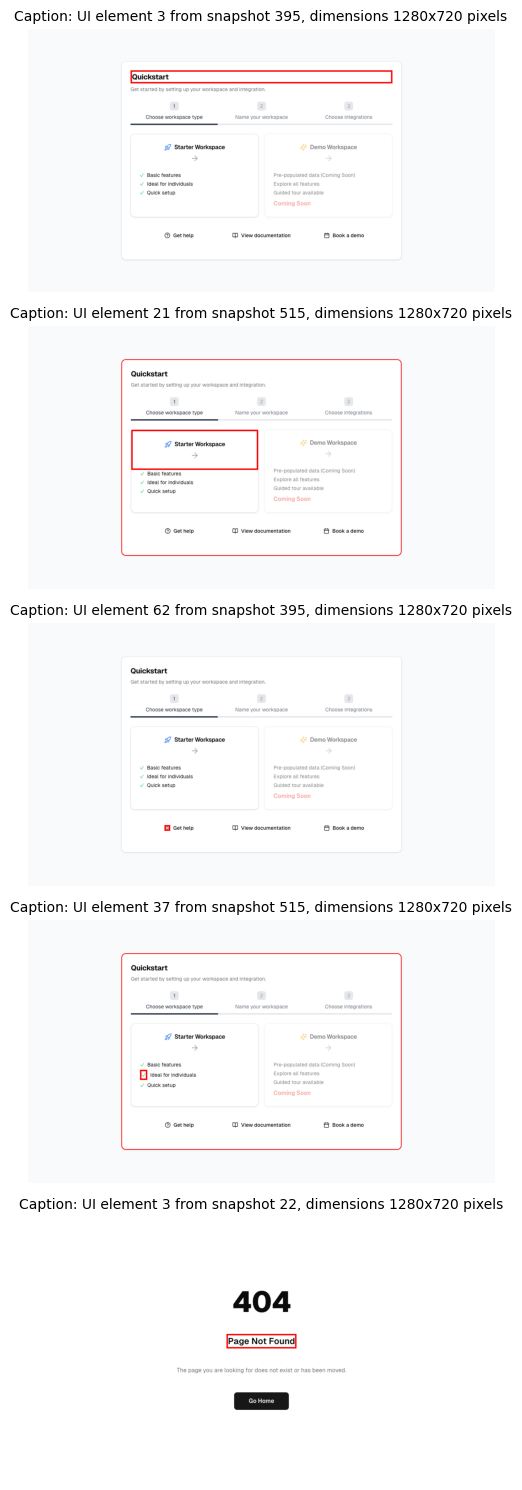


Process complete! Your dataset is now available at:
https://huggingface.co/datasets/Slyracoon23/rrvideo-element-highlights


In [16]:
def visualize_samples(dataset, num_samples=5):
    """Visualize random samples from the dataset"""
    if len(dataset) < num_samples:
        num_samples = len(dataset)
    
    indices = np.random.randint(0, len(dataset), num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples * 3))
    if num_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        sample = dataset[int(idx)]
        image = sample["image"]
        caption = sample["caption"]
        
        axes[i].imshow(image)
        axes[i].set_title(f"Caption: {caption}", fontsize=10)
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.savefig(os.path.join(PROCESSED_DATA_DIR, "sample_visualizations.png"))
    plt.show()

# Visualize samples from the training set
print("Visualizing samples from the training set...")
visualize_samples(dataset_dict["train"])

print("\nProcess complete! Your dataset is now available at:")
print(f"https://huggingface.co/datasets/{HF_USERNAME}/{DATASET_NAME}")